In [1]:
import matplotlib.pyplot as plt
from matplotlib import rc
plt.style.use('ggplot')
import torch
from torch.nn.functional import softmax
import numpy as np
from torch.autograd import Variable
from torch.distributions import uniform, cauchy, normal, relaxed_bernoulli
import ipdb

In [2]:
def sigmoid(x):
    return 1. / (1 + torch.exp(-1*(x)))

def normalize(x):
    return x / torch.sqrt((x**2).sum())

In [3]:
# Center logits so that they have a given sigmoidal value using Newton's method

def sig_newton(x, p_bar, threshold = 1e-7, max_steps=100):
    guess = Variable(torch.tensor(0.0), requires_grad=True)
    value = sigmoid(x - guess).mean() - p_bar
    counter = 0
    while abs(value.data.numpy()) > threshold and counter < max_steps:
        value = sigmoid(x - guess).mean() - p_bar
        value.backward()
        guess.data -= (value / guess.grad).data
        guess.grad.data.zero_()
        counter += 1
    return guess.data

In [4]:
# Fetch distribution objects for intrinsic frequencies

def get_dist(dist_name,):
    if dist_name == 'cauchy':
        loc = 0.0
        scale = .1
        dist = cauchy.Cauchy(loc, scale)
        g0 = torch.exp(dist.log_prob(loc))
        return dist, g0
    elif dist_name == 'uniform':
        high = 1.0
        low = -1.0
        g0 = 1. / (high - low)
        dist = uniform.Uniform(-1.0, 1.0)
        return dist, g0

In [5]:
# Networks

# Predict connectivity from omega
class connectivity_net(torch.nn.Module):
    def __init__(self, num_in, num_hid=256):
        super(connectivity_net, self).__init__()
        self.num_out = int(num_in * (num_in - 1) / 2.)
#         self.average_p = torch.tensor(average_p)
        self.layers = torch.nn.Sequential(torch.nn.Linear(num_in, num_hid),
                         torch.nn.ReLU(),
                         torch.nn.Linear(num_hid,num_hid),
                         torch.nn.ReLU(),
                         torch.nn.Linear(num_hid,self.num_out))

    def forward(self,x, center=False):        
        logits = self.layers(x)
#         p = softmax(logits,dim=-1)
#       p = sigmoid(logits)
        p = normalize(logits)
        return p

# Predict omega from connectivity
class omega_net(torch.nn.Module):
    def __init__(self, num_in, std=.57, min_freq=-1.0, max_freq=1.0, num_hid=256):
        super(omega_net, self).__init__()
        self.min_freq = min_freq
        self.max_freq = max_freq
        self.std = std
        
        self.num_out = int(.5*(1 + np.sqrt(1 + 8*num_in)))
        self.layers = torch.nn.Sequential(torch.nn.Linear(num_in, num_hid),
                         torch.nn.ReLU(),
                         torch.nn.Linear(num_hid,num_hid),
                         torch.nn.ReLU(),
                         torch.nn.Linear(num_hid,self.num_out))

    def forward(self,x):
        omega = self.layers(x)
        mu = omega.mean(1).unsqueeze(1)
        omega = omega - mu
        sig = omega.std(1).unsqueeze(1)
        omega = omega * (self.std / sig)
        return omega

In [6]:
# Loss functions and statistics

def circular_variance(phases):
    num_phases = phases.shape[2]
    xx = torch.cos(phases)
    yy = torch.sin(phases)
    return (1 - (torch.sqrt(xx.sum(2)**2 + yy.sum(2)**2) / num_phases)).mean()

def c_omega(omega, connectivity):
    omega_bar = omega.mean(1).unsqueeze(1)
    num = (connectivity * torch.einsum('bi,bj->bij',(omega - omega_bar) ,(omega - omega_bar) )).sum((1,2))
    den = (connectivity * (omega - omega_bar).unsqueeze(1)**2).sum((1,2))
    return (num / den + 1e-6).mean()

def laplacian(connectivity,sym_norm=True):
    A = connectivity
    D = torch.diag_embed(A.sum(1))
    D_mask = torch.diag_embed(torch.ones_like(A.sum(1)))
    L = D-A
    D2neg = torch.where(D_mask.bool(), D**(-.5),torch.zeros_like(D))
    D2 = torch.where(D_mask.bool(), D**(.5),torch.zeros_like(D))
    D2neg = torch.where(torch.isinf(D2neg), torch.zeros_like(D2neg),D2neg)
    if sym_norm:
        return torch.bmm(D2neg,torch.bmm(L,D2))
    else:
        return L

def p_neg(omega, connectivity):
    num_units = omega.shape[1]
#     num_ut = int(num_units * (num_units - 1) / 2)
    sign_omega = torch.sign(omega)
    sign_prods = torch.einsum('bi,bj->bij',sign_omega, sign_omega)
    num_connections = (connectivity > 0).sum((1,2))
    opp_connections = (sign_prods * connectivity) < 0
    return ((opp_connections.sum((1,2))) / num_connections.float()).mean()

In [7]:
def run_kuramoto(coupling, omega, eps=.1, steps=100, phase_init=None, burn_in_prop=.5):
    
    num_units = coupling.shape[2]
    burn_in_steps = int(burn_in_prop * steps)
    
    if phase_init == None:
        phase = np.pi*torch.ones((1,num_units))
    else:
        phase = phase_init
    flow = []
    for i in range(steps):
        phase = kuramoto_step(phase,coupling,omega,eps=eps)
        flow.append(phase)
    flow = torch.stack(flow).transpose(1,0)
    truncated_flow = flow[:,burn_in_steps:,:]
    cv = circular_variance(truncated_flow).detach().numpy()
    return cv, flow.detach().numpy()

# def kuramoto_step(phase, coupling, omega, eps=.01):
#     delta = eps * ( omega + \
#                      (torch.bmm(coupling, torch.sin(phase).unsqueeze(2).float()).squeeze(2) * torch.cos(phase) -
#                      torch.bmm(coupling, torch.cos(phase).unsqueeze(2).float()).squeeze(2) * torch.sin(phase)))
#     return phase + delta

def kuramoto_step(phase, coupling, omega, eps=.01):
    phase_diffs = torch.sin(phase.unsqueeze(-1) - phase.unsqueeze(-2))
    delta = eps * (omega + (coupling * phase_diffs).sum(1))
    return phase + delta

In [8]:
# Optimize connectivity network

def optimize_connectivity_net(num_units, omega_name='uniform',iterations=100, kuramoto_steps=100, burn_in_prop = .5, 
                      lr=.01, eps=.1,coupling_strength = .7, average_d=3.5, batch_size=256):
    
    
    # Initial stuff
    omega_dist, g0 = get_dist(omega_name)
    cn = connectivity_net(num_units, num_hid=512)
    Kc = 2 / (np.pi * g0)

    opt = torch.optim.Adam(cn.parameters(), lr=lr)
    cvh = []
    co = []
    pn = []
    num_burn_in = int(burn_in_prop * kuramoto_steps)
    num_connections = int(average_d*num_units * .5)
    
    triu_ind = torch.triu_indices(row=num_units, col=num_units, offset=1)
    tril_ind = torch.tril_indices(row=num_units, col=num_units, offset=1)
    for i in range(iterations):
        omega = omega_dist.sample(sample_shape=torch.Size([batch_size,num_units]))
        
        opt.zero_grad()
        
        phase = np.pi * torch.ones(batch_size,num_units)
        flow = []
        connectivity = torch.zeros((batch_size, num_units, num_units))
        soft_connectivity = cn.forward(omega)
        _, hard_inds = torch.topk(soft_connectivity,num_connections, dim=-1)
        hard_connectivity = torch.zeros_like(soft_connectivity).scatter_(1,hard_inds, torch.ones_like(hard_inds).float())
        ut_connectivity = hard_connectivity - soft_connectivity.detach() + soft_connectivity
        
        connectivity[:,triu_ind[0],triu_ind[1]] = ut_connectivity
        connectivity += connectivity.transpose(2,1)
        for k in range(kuramoto_steps):
            phase = kuramoto_step(phase, coupling_strength*connectivity, omega, eps=eps)
            flow.append(phase)
        flow = torch.stack(flow).transpose(1,0)
        truncated_flow = flow[:,num_burn_in:,:]
        cv = circular_variance(truncated_flow)
        cvh.append(cv.detach().cpu().numpy())
        cv.backward()
        opt.step()
        
        co.append(c_omega(omega, connectivity).detach().numpy())
        pn.append(p_neg(omega,connectivity).detach().numpy())
    return cvh, cn, co, pn

In [9]:
# Optimize connectivity directly

def optimize_connectivity(num_units, omega,iterations=100, kuramoto_steps=100, burn_in_prop = .5, lr=.01,
                      coupling_strength = .7, average_d = 3.5, num_samples=128,
                      eps=.01):

    # Initialize coupling
    num_connections = int(average_d*num_units * .5)
    ut_size = int(num_units * (num_units - 1) / 2)
    logits = Variable(1. / (ut_size)*torch.ones(ut_size), requires_grad = True)
   
    opt = torch.optim.Adam([logits,], lr=lr)
    cvh = []
    ph = []
    co = []
    pn = []
    temp = np.linspace(.1, 0.001, iterations)
    num_burn_in = int(burn_in_prop * kuramoto_steps)
    
    triu_ind = torch.triu_indices(row=num_units, col=num_units, offset=1)
    tril_ind = torch.tril_indices(row=num_units, col=num_units, offset=1)

    for i in range(iterations):
        
        opt.zero_grad()
        phase = np.pi * torch.ones(1,num_units)

        flow = []
        connectivity = torch.zeros((1, num_units, num_units))

#         soft_connectivity = softmax(logits)
        soft_connectivity = normalize(logits)
#         soft_connectivity = logits
        _, hard_inds = torch.topk(soft_connectivity,num_connections, dim=-1)
        hard_connectivity = torch.zeros_like(soft_connectivity).scatter_(0,hard_inds, torch.ones_like(hard_inds).float())
        ut_connectivity = hard_connectivity - soft_connectivity.detach() + soft_connectivity
        
        connectivity[:,triu_ind[0],triu_ind[1]] = ut_connectivity
        connectivity += connectivity.transpose(2,1)

        coupling = coupling_strength * connectivity
        for k in range(kuramoto_steps):
            phase = kuramoto_step(phase, coupling, omega, eps=eps)
            flow.append(phase)
        flow = torch.stack(flow).transpose(1,0)
        truncated_flow = flow[:,num_burn_in:,:]
        cv = circular_variance(truncated_flow)
        cvh.append(cv.detach().cpu().numpy())
        cv.backward()
        opt.step()
        
        co.append(c_omega(omega, connectivity).detach().numpy())
        pn.append(p_neg(omega,connectivity).detach().numpy())

    return np.array(cvh), logits.detach().cpu().numpy(), connectivity.cpu().detach().numpy(), flow.detach().numpy(), co, pn

In [10]:
# Optimize connectivity net regularized to output fixed-mean coupling probabilities

def optimize_regularized_connectivity_net(num_units, omega_name='uniform',iterations=100, kuramoto_steps=100, burn_in_prop = .5, 
                      lr=.01, eps=.1,coupling_strength = .7, average_d=.035, batch_size=256,
                                          eta=1.0, init_steps=25, init_lr=.001):
    
    # Initial stuff
    omega_dist, g0 = get_dist(omega_name)
    cn = connectivity_net(num_units, average_p=average_p, num_hid=512)
    
    opt = torch.optim.Adam(cn.parameters(), lr=init_lr)
    # Initialize
    init_loss = torch.tensor(1.0)
    init_lh = []
    while init_loss.detach().numpy() > 1e-5:
        opt.zero_grad()
        omega = omega_dist.sample(sample_shape=torch.Size([batch_size,num_units]))
        soft_connectivity = cn.forward(omega, center=False)
        sample_p = soft_connectivity.mean()
        init_loss = (sample_p - average_p)**2
        init_lh.append(init_loss.detach().numpy())
        init_loss.backward()
        opt.step()
                
    # Check
#     plt.plot(init_lh)
#     plt.show()
#     plt.close()
#    print('Initial p: {}'.format(sample_p.detach().numpy()))
    cvh = []
    co = []
    pn = []
    ap = []
    num_burn_in = int(burn_in_prop * kuramoto_steps)
    
    triu_ind = torch.triu_indices(row=num_units, col=num_units, offset=1)
    tril_ind = torch.tril_indices(row=num_units, col=num_units, offset=1)
    delta_loss = -1.
    old_loss = torch.tensor(float('inf'))
    while delta_loss < 0:
        omega = omega_dist.sample(sample_shape=torch.Size([batch_size,num_units]))
        
        opt.zero_grad()
        
        phase = np.pi * torch.ones(batch_size,num_units)
        flow = []
        connectivity = torch.zeros((batch_size, num_units, num_units))
        #connectivity_logits =  cn.forward(omega)
        soft_connectivity = cn.forward(omega, center=False)
        sample_p = soft_connectivity.mean()
        ap.append(sample_p.detach().numpy())
        #soft_connectivity = 1. / (1 + torch.exp(-1*connectivity_logits))
        hard_connectivity = 1.0*(torch.rand_like(soft_connectivity) < soft_connectivity)
        ut_connectivity = hard_connectivity - soft_connectivity.detach() + soft_connectivity
        
        connectivity[:,triu_ind[0],triu_ind[1]] = ut_connectivity
        connectivity += connectivity.transpose(2,1)
        for k in range(kuramoto_steps):
            phase = kuramoto_step(phase, coupling_strength*connectivity, omega, eps=eps)
            flow.append(phase)
        flow = torch.stack(flow).transpose(1,0)
        truncated_flow = flow[:,-1*(kuramoto_steps - num_burn_in):,:]
        cv = circular_variance(truncated_flow)
        cvh.append(cv.detach().cpu().numpy())
#         loss = cv + eta * (sample_p - average_p)**2
        sparsity_loss = -1*(average_p * torch.log(soft_connectivity) + (1-average_p)*torch.log(1 - soft_connectivity)).mean()
        loss = cv + eta*sparsity_loss
        delta_loss = loss - old_loss
        loss.backward()
        old_loss=loss
        opt.step()
        
        co.append(c_omega(omega, connectivity).detach().numpy())
        pn.append(p_neg(omega,connectivity).detach().numpy())
    return cvh, cn, co, pn, ap

In [11]:
# Optimize omegas to synchronize different couplings

def optimize_omega_net(num_units,iterations=100, kuramoto_steps=100, burn_in_prop = .5, 
                      lr=.01, eps=.1,coupling_strength = .7, average_p = .035, 
                       omega_std=.57, allow_neg_couplings=False,
                       min_freq=-1.0, max_freq=1.0, batch_size=256):
    
    
    # Initial stuff
    num_ut = int((num_units )*(num_units - 1) / 2)
    on = omega_net(num_ut, std=omega_std, min_freq=min_freq, max_freq=max_freq, num_hid=512)    

    opt = torch.optim.Adam(on.parameters(), lr=lr)
    cvh = []
    num_burn_in = int(burn_in_prop * kuramoto_steps)
    
    triu_ind = torch.triu_indices(row=num_units, col=num_units, offset=1)
    tril_ind = torch.tril_indices(row=num_units, col=num_units, offset=1)
    for i in range(iterations):
        
        opt.zero_grad()
        ut_connectivity = 1.*(torch.rand((batch_size,num_ut)) < average_p)

        if allow_neg_couplings:
            ut_connectivity *= (1*(torch.rand((batch_size, num_ut)) < .5) - .5)*2.
        ut_connectivity = ut_connectivity * coupling_strength
        omega =  on.forward(ut_connectivity)
        
        connectivity = torch.zeros((batch_size, num_units, num_units))
        connectivity[:,triu_ind[0],triu_ind[1]] = ut_connectivity
        connectivity = connectivity + connectivity.transpose(2,1)
        
        phase = np.pi * torch.ones(batch_size,num_units)
        flow = []        
        for k in range(kuramoto_steps):
            phase = kuramoto_step(phase, connectivity, omega, eps=eps)
            flow.append(phase)
        flow = torch.stack(flow).transpose(1,0)
        truncated_flow = flow[:,-1*(kuramoto_steps - num_burn_in):,:]
        cv = circular_variance(truncated_flow)
        cvh.append(cv.detach().cpu().numpy())
        cv.backward()
        opt.step()
    return cvh, on

In [14]:
# Brede 1: Parameters
num_units = 120
omega_name = 'uniform'
sigma = np.linspace(.1, 1.6, 10)
sigma_star = .7
num_phase_init = 10
average_d = 3.5
iterations = 1000
burn_in_prop=.0
eps=.01
lr=1e-1
kuramoto_steps=1000
triu_ind = torch.triu_indices(row=num_units, col=num_units, offset=1)

#cv over 10 random seeds for 120 units, no burn in: 
# [0.014125732, 0.02325307, 0.040731754, 
#  0.05252464, 0.0538469, 0.058091756, 0.101729386, 
#  0.1097575, 0.16743797, 0.17231707]

In [18]:
# Brede 1: Optimize for single omega vector
all_cv = []
for seed in range(10):
    print(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    omega_dist, g0 = get_dist(omega_name)

    omega = omega_dist.sample(sample_shape=torch.Size([1,num_units]))
    cv_star,logits_star, connectivity_star, flow_star,co, pn = optimize_connectivity(num_units, omega,
                                                              coupling_strength=sigma_star,
                                                              average_d= average_d, iterations=iterations,
                                                              eps=eps, lr=lr, kuramoto_steps=kuramoto_steps,
                                                              burn_in_prop=burn_in_prop)
    all_cv.append(cv_star.min())


0
1
2
3
4
5
6
7
8
9


[0.014125732, 0.02325307, 0.040731754, 0.05252464, 0.0538469, 0.058091756, 0.101729386, 0.1097575, 0.16743797, 0.17231707]


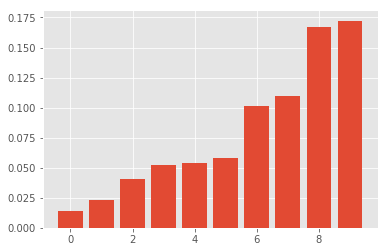

In [33]:
print(all_cv)
plt.bar(np.arange(10),all_cv)
#plt.bar([i for i, _ in enumerate(all_cv)], all_cv.sort())
plt.show()
plt.close()

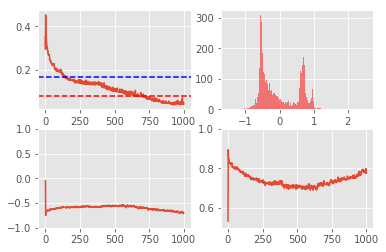

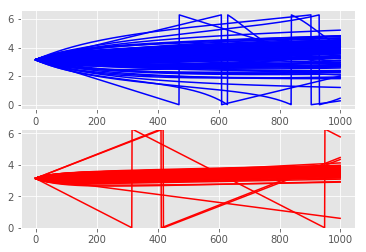

0.040731754


In [35]:
# Brede 1: Show loss and evolved coupling probabilities
# sigma_star=.1
fig, axes = plt.subplots(2,2)
axes[0,0].plot(cv_star)

# Control
batch_size=1024
num_connections = int(average_d * num_units * .5)
num_burn_in = int(burn_in_prop * kuramoto_steps)
connectivity = torch.zeros((batch_size,num_units, num_units))
logits = torch.rand((batch_size, int(num_units * (num_units - 1) / 2)))
# soft_connectivity = softmax(logits)
soft_connectivity = normalize(logits)
_, hard_inds = torch.topk(soft_connectivity,num_connections, dim=-1)
hard_connectivity = torch.zeros_like(soft_connectivity).scatter_(-1,hard_inds, torch.ones_like(hard_inds).float())
connectivity[:,triu_ind[0],triu_ind[1]] = hard_connectivity
connectivity += connectivity.transpose(2,1)
coupling = connectivity * sigma_star

phase = np.pi * torch.ones(batch_size,num_units)
flow = []
for k in range(kuramoto_steps):
    phase = kuramoto_step(phase, coupling, omega, eps=eps)
    flow.append(phase)
flow = torch.stack(flow).transpose(1,0)
truncated_flow = flow[:,-1*(kuramoto_steps - num_burn_in):,:]
cv_control = circular_variance(truncated_flow)
axes[0,0].axhline(y=cv_control.numpy(),color='b', linestyle='--')
axes[0,0].axhline(y=np.mean(all_cv),color='r', linestyle='--')


# Plot
axes[0,1].hist(logits_star,250,color='r',alpha=.5)
# axes[1].axvline(x=average_p,color='b', linestyle='--')
#axes[0,1].set_xlim([0,.0006])

axes[1,0].plot(co)
axes[1,0].set_ylim([-1,1])
axes[1,1].plot(pn)
axes[1,1].set_ylim([.5,1])


plt.show()
plt.close()

fig, axes = plt.subplots(2)
flow = (flow % ((2*np.pi) + 2*np.pi)) % (2*np.pi)
flow_star = (flow_star % ((2*np.pi) + 2*np.pi)) % (2*np.pi)
axes[0].plot(flow[3,...],color='b')
axes[1].plot(flow_star[0,...],color='r')
plt.ylim([0,2*np.pi])
plt.show()
plt.close()
print(cv_star.min())

In [15]:
# For multiple phase initializations, compute circular variance of optimized vs random
num_phase_init=25
R = []
R_control = []
for sig in np.linspace(.05,1.6,25):
    rbs_p = []
    rbs_p_control = []
    for p in range(num_phase_init):
        p_star = 1. / (1 + torch.exp(-1 * torch.tensor(logits_star)))
        p_control = torch.rand(int(num_units * (num_units - 1) / 2))
        connectivity_star = torch.zeros((1,num_units,num_units))
        control_connectivity = torch.zeros((1,num_units,num_units))
        cmx = [connectivity_star, control_connectivity]

        for j, prob in enumerate([p_star, p_control]):
            if j == 0:
                ut_connectivity = 1.*(torch.rand_like(prob) < prob)
            else:
                ut_connectivity = 1.*(torch.rand_like(prob) < average_p)
            cmx[j][:,triu_ind[0],triu_ind[1]] = ut_connectivity
            cmx[j] += cmx[j].transpose(2,1)  
        phase_init = 2*np.pi*torch.rand((1,num_units))

        cv, _ = run_kuramoto(sig * cmx[0], omega, phase_init=phase_init, eps=eps)
        rbs_p.append(cv)
        
        cv_control, fl_control = run_kuramoto(sig * cmx[1], omega, phase_init=phase_init,eps=eps)
        rbs_p_control.append(cv_control)
    R.append(np.mean(rbs_p))
    R_control.append(np.mean(rbs_p_control))


NameError: name 'logits_star' is not defined

In [11]:
# Brede 1: Plot synchrony per sigma

plt.plot(np.linspace(.05,1.6,25), 1 - np.array(R), color='r')
plt.plot(np.linspace(.05,1.6,25), 1 - np.array(R_control), color='b')
plt.legend(('Optimized', 'Control'))
plt.xlabel('Sigma')
plt.ylabel('Global synchrony')
plt.show()
plt.close()

NameError: name 'R' is not defined

In [271]:
# Brede 2 (Coupling network): Parameters
num_units = 10
batch_size=256
omega_name = 'uniform'
num_omega = 10
sigma = np.linspace(.05, 1.5, 25)
sigma_star = .7
num_phase_init = 10
average_d = 3.5
burn_in_prop = 0.0
iterations = 100
eps=.1
lr=1e-2
init_lr=1e-2
eta=1e1
kuramoto_steps=100
triu_ind = torch.triu_indices(row=num_units, col=num_units, offset=1)
triu_ind_c = torch.triu_indices(row=3000, col=3000, offset=1)

In [272]:
# Brede 2: Optimize regularized coupling net

cv_star, cn, co, pn = optimize_connectivity_net(num_units, omega_name=omega_name,
                                        coupling_strength=sigma_star,
                                        average_d= average_d, iterations=iterations,
                                        eps=eps, lr=lr, kuramoto_steps=kuramoto_steps, burn_in_prop=burn_in_prop)
# cv_opt = []
#cv_control = []
# p_opt = []

# for eta in np.linspace(1e-3, 1, 10):
#     cv_star, cn, co, pn, ap = optimize_regularized_connectivity_net(num_units, omega_name=omega_name,
#                                         coupling_strength=sigma_star,
#                                         average_p= average_p, iterations=iterations,
#                                         eps=eps, lr=lr, eta=eta, init_lr=init_lr, kuramoto_steps=kuramoto_steps)
#     cv_opt.append(cv_star[-1])
#     p_opt.append(ap[-1])

# p_opt = np.linspace(.01,1.0,100)
# omega_dist, g0 = get_dist(omega_name)

# for p, prob in enumerate(p_opt):
    
#     omega = omega_dist.sample(sample_shape=torch.Size([batch_size,num_units]))
#     connectivity_star = torch.zeros((1,num_units,num_units))
#     control_connectivity = torch.zeros((batch_size,num_units,num_units))

#     ut_connectivity = 1.*(torch.rand((batch_size, int(num_units*(num_units - 1) / 2))) < torch.tensor(prob))
#     control_connectivity[:,triu_ind[0],triu_ind[1]] = ut_connectivity
#     control_connectivity += control_connectivity.transpose(2,1)          
    
#     phase_init = np.pi*torch.ones((batch_size,num_units))
#     cvc, fc = run_kuramoto(sigma_star * control_connectivity, omega, phase_init=phase_init,eps=eps)
#     phases = fc[0,...]
#     phases = (phases % ((2*np.pi) + 2*np.pi)) % (2*np.pi)
#     plt.plot(phases, color='b', alpha=.5)
#     plt.ylim([0,2*np.pi])
#     plt.show()
#     ipdb.set_trace()
#     cv_control.append(cvc)


NameError: name 'T' is not defined

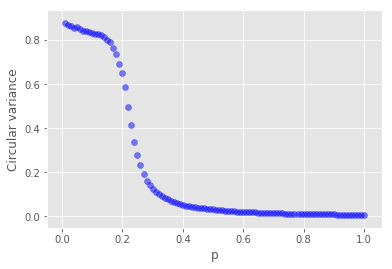

In [77]:
# plt.scatter(p_opt, cv_opt, color='r', alpha=.5)
plt.scatter(p_opt, cv_control, color='b', alpha=.5)
plt.xlabel('p')
plt.ylabel('Circular variance')
plt.show()
plt.close()

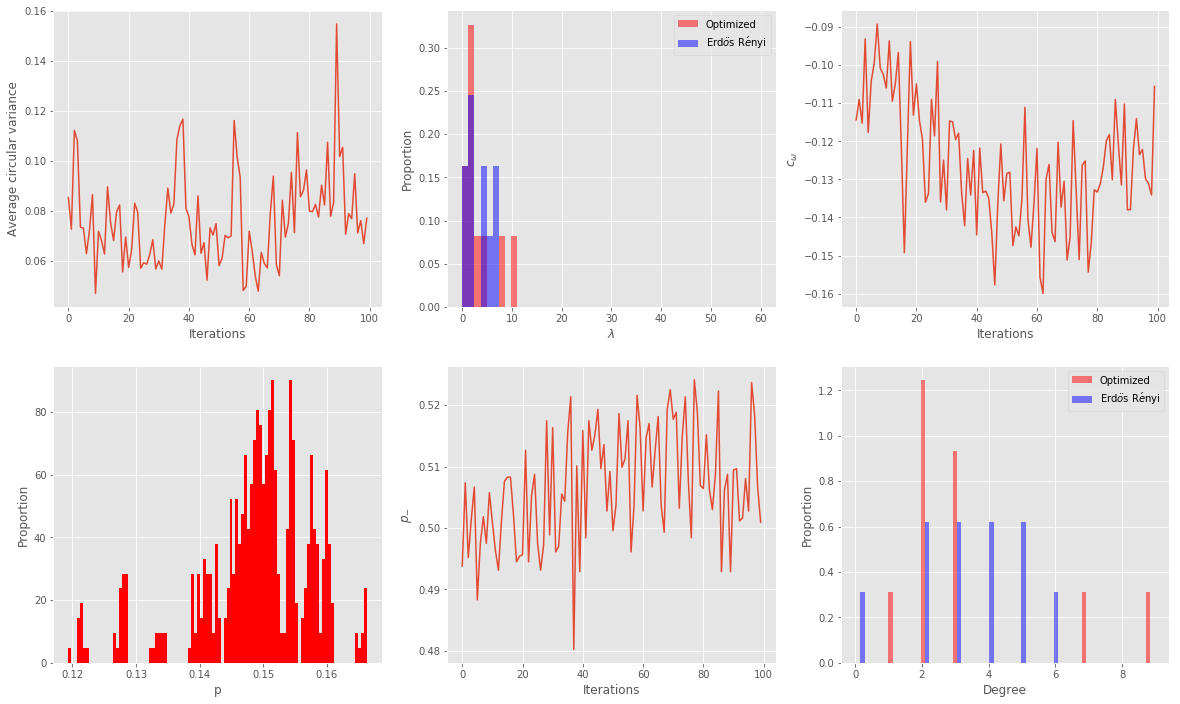

In [269]:
# Brede 2: Show loss and evolved coupling probabilities
batch_size=1
num_ut = int(num_units * (num_units - 1) / 2)
num_connections = int(average_d * .5 * num_units)
fig, axes = plt.subplots(2,3,figsize=(20,12))
axes[0,0].plot(np.arange(0,iterations), cv_star)
axes[0,0].set_xlabel('Iterations')
axes[0,0].set_ylabel('Average circular variance')

omega_dist, g0 = get_dist(omega_name)
omega = omega_dist.sample(sample_shape=torch.Size([batch_size,num_units]))

connectivity_star = torch.zeros((batch_size,num_units,num_units))
control_connectivity = torch.zeros((batch_size,num_units,num_units))
cmx = [connectivity_star, control_connectivity]

for j, mx in enumerate(cmx):
    prob = cn.forward(omega) if j == 0 else torch.rand(batch_size, num_ut)
    _, hard_inds = torch.topk(prob,num_connections, dim=-1)
    ut_connectivity = torch.zeros_like(prob).scatter_(1,hard_inds, torch.ones_like(hard_inds).float())
    cmx[j][:,triu_ind[0],triu_ind[1]] = ut_connectivity
    cmx[j] += cmx[j].transpose(2,1)          

evals = []
evals_control = []
D = cmx[0].sum(1).reshape(-1).numpy()
D_control = cmx[1].sum(1).reshape(-1).numpy()

lp = laplacian(cmx[0])
lp_control = laplacian(cmx[1])

for b in range(batch_size):
    evl_control, _ = torch.eig(lp_control[b,...])
    evl, _ = torch.eig(lp[b,...])
    evals.append(evl[:,0].numpy())
    evals_control.append(evl_control[:,0].numpy())

bins = np.linspace(0,60,50)
axes[0,1].hist(np.array(evals).reshape(-1), bins=bins, color='r',alpha=.5, density=True)
axes[0,1].hist(np.array(evals_control).reshape(-1), bins=bins, color='b',alpha=.5, density=True)
axes[0,1].set_xlabel(r'$\lambda$')
axes[0,1].set_ylabel('Proportion')
axes[0,1].legend(('Optimized', r'Erd$\"{o}$s R$\'{e}$nyi'))
#axes[1].set_ylim([0,.25])

axes[0,2].plot(np.array(co).reshape(-1))
axes[0,2].set_ylabel(r'$c_{\omega}$')
axes[0,2].set_xlabel('Iterations')

all_p=[]
omega_dist, g0 = get_dist(omega_name)
for o in range(num_omega):
    omega = omega_dist.sample(sample_shape=torch.Size([batch_size,num_units]))
    p = cn.forward(omega)
    all_p.append(p.detach().numpy())
all_p = np.array(all_p).reshape(-1)
#ipdb.set_trace()
#logbins = np.geomspace(all_p.min(), all_p.max(), 1000)
axes[1,0].hist(np.array(all_p).reshape(-1),bins=100,color='r', density=True)
#axes[1,0].axvline(x=average_p,color='b',linestyle='--')
#axes[1,0].set_xlim([0,1.5])
#axes[1,0].set_ylim([0,15])
#axes[1,0].set_yscale('log')
#axes[1,0].set_xscale('log')

#axes[2].set_yticklabels([])
axes[1,0].set_ylabel('Proportion')
axes[1,0].set_xlabel('p')

axes[1,1].plot(np.array(pn))
axes[1,1].set_ylabel(r'$p_{-}$')
axes[1,1].set_xlabel('Iterations')


all_D = np.array([D, D_control]).transpose()
axes[1,2].hist(all_D,28,color=('r','b'),alpha=.5,histtype='bar',density=True)
axes[1,2].set_xlabel('Degree')
axes[1,2].set_ylabel('Proportion')
axes[1,2].legend(('Optimized', r'Erd$\"{o}$s R$\'{e}$nyi'))

plt.show()
plt.close()

In [131]:
nomega_dist, g0 = get_dist(omega_name)
r_o = []
r_o_control = []
sigma=[.7]
for o in range(num_omega):
    omega = omega_dist.sample(sample_shape=torch.Size([1,num_units]))
    r_s = []
    r_s_control = []
    for sig in sigma:

        r_p = []
        r_p_control = []
        logits_star = cn.forward(omega)
        p_star = 1. / (1 + torch.exp(-1 * torch.tensor(logits_star)))
        
        p_control = torch.rand(int(num_units * (num_units - 1) / 2))
        connectivity_star = torch.zeros((1,num_units,num_units))
        control_connectivity = torch.zeros((1,num_units,num_units))
        cmx = [connectivity_star, control_connectivity]

        for j, prob in enumerate([p_star, p_control]):
            if j == 0:
                ut_connectivity = 1.*(torch.rand_like(prob) < prob)
            else:
                ut_connectivity = 1.*(torch.rand_like(prob) < average_p)
            cmx[j][:,triu_ind[0],triu_ind[1]] = ut_connectivity
            cmx[j] += cmx[j].transpose(2,1)          
        for p in range(num_phase_init):

            phase_init = 2*np.pi*torch.rand((1,num_units))

            cv, fl_opt = run_kuramoto(sig * cmx[0], omega, phase_init=phase_init, eps=eps)
            cv_control, fl_control = run_kuramoto(sig * cmx[1], omega, phase_init=phase_init,eps=eps)
            r_p.append(cv)
            r_p_control.append(cv_control)
        # Average over initializations for this sigma
        r_s.append(np.mean(r_p))
        r_s_control.append(np.mean(r_p_control))

    # R averaged over omega
    r_o.append(np.array(r_s))
    r_o_control.append(np.array(r_s_control))
R = np.array(np.array(r_o).mean(0))
R_err = np.array(r_o).std(0)
R_control = np.array(np.array(r_o_control).mean(0))
R_control_err = np.array(r_o_control).std(0)

/home/matt/newtorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


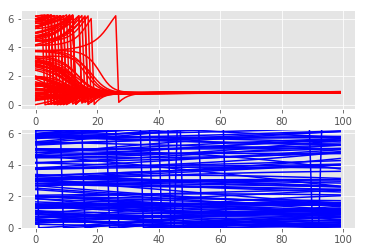

In [54]:
fl_opt = (fl_opt % ((2*np.pi) + 2*np.pi)) % (2*np.pi)
fl_control = (fl_control % ((2*np.pi) + 2*np.pi)) % (2*np.pi)

fig, axes = plt.subplots(2,1)
axes[0].plot(fl_opt[0,...], color='r')
axes[1].set_ylim([0,2*np.pi])
axes[1].plot(fl_control[0,...], color='b')
axes[1].set_ylim([0,2*np.pi])

plt.show()
plt.close()

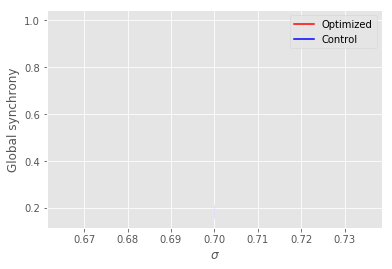

In [116]:
# Brede 2: Plot synchrony per sigma averaged over omega
synchrony = 1 - np.array(R)
synchrony_control = 1 - np.array(R_control)
plt.plot(sigma, synchrony, color='r')
plt.fill_between(sigma, synchrony-R_err, synchrony+R_err,
    alpha=0.2, edgecolor='r', facecolor='r',antialiased=True)
plt.plot(sigma, 1 - np.array(R_control), color='b')
plt.fill_between(sigma, synchrony_control-R_control_err, synchrony_control+R_control_err,
    alpha=0.2, edgecolor='b', facecolor='b',antialiased=True)
plt.legend(('Optimized', 'Control'))
plt.xlabel(r'$\sigma$')
plt.ylabel('Global synchrony')
plt.show()
plt.close()

In [98]:
# Brede 3: Optimal intrinsic frequencies for given coupling
num_units = 100
max_freq=1.0
min_freq=-1.0
omega_std = .57
num_adjacency=10
batch_size=256
allow_neg_couplings=True
sigma = np.linspace(-1.5, 1.5, 30)
sigma_star = .7
num_phase_init = 1
average_logit = -3.36
average_p = 1./(1 + np.exp(-1*average_logit))
iterations = 1000
eps=.1
lr=.01
kuramoto_steps=1000
triu_ind = torch.triu_indices(row=num_units, col=num_units, offset=1)

In [80]:
cv_star, on = optimize_omega_net(num_units,coupling_strength=sigma_star, average_p=average_p, omega_std=omega_std,
                                        min_freq=min_freq, max_freq=max_freq, iterations=iterations, 
                                        allow_neg_couplings=allow_neg_couplings,
                                        eps=eps, lr=lr, kuramoto_steps=kuramoto_steps)


KeyboardInterrupt: 

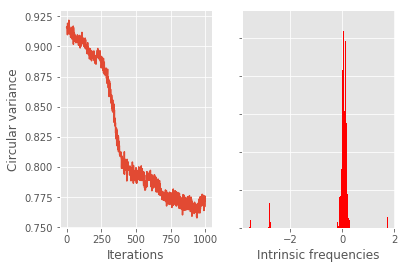

In [59]:
fig, axes = plt.subplots(1,2)
axes[0].plot(cv_star)
axes[0].set_xlabel('Iterations')
axes[0].set_ylabel('Circular variance')

num_ut=int(num_units*(num_units - 1) / 2)
ut_connectivity = 1.*(torch.rand((batch_size,num_ut)) < average_p)

if allow_neg_couplings:
    ut_connectivity *= (1*(torch.rand((batch_size, num_ut)) < .5) - .5)*2.

omega =  on.forward(sigma_star*ut_connectivity).reshape(-1).detach().numpy()

axes[1].hist(omega, 1000, color='r', density=True)
#axes[1].set_xlim([-.5,.5])
axes[1].set_xlabel('Intrinsic frequencies')
axes[1].set_yticklabels([])

plt.show()
plt.close()


In [101]:
r_o = []
r_o_control = []
for a in range(num_adjacency):
    ut_connectivity = 1.*(torch.rand((batch_size,num_ut)) < average_p)
    if allow_neg_couplings:
        ut_connectivity *= (1*(torch.rand((batch_size, num_ut)) < .5) - .5)*2.    
    
    connectivity = torch.zeros((batch_size, num_units, num_units))
    connectivity[:,triu_ind[0],triu_ind[1]] = ut_connectivity
    connectivity = connectivity + connectivity.transpose(2,1)
    
    r_s = []
    r_s_control = []
    for sig in sigma:
        coupling = sig * connectivity

        omega_star = on.forward(sig*ut_connectivity)
        omega_control = 2*(torch.rand_like(omega_star) - .5)   
        
        phase_init = 2.0*np.pi*torch.rand((batch_size,num_units)) 
        #phase_init = np.pi*torch.ones((batch_size,num_units)) + 4*torch.rand((batch_size,num_units)) - 2.0
        cv, _ = run_kuramoto(coupling, omega_star, phase_init=phase_init, eps=eps)
        cv_control, fl_control = run_kuramoto(coupling, omega_control, phase_init=phase_init,eps=eps)

        # Average over initializations for this sigma
        r_s.append(cv)
        r_s_control.append(cv_control)
    
    # R averaged over omega
    r_o.append(np.array(r_s))
    r_o_control.append(np.array(r_s_control))
R = np.array(np.array(r_o).mean(0))
R_err = np.array(r_o).std(0)
R_control = np.array(np.array(r_o_control).mean(0))
R_control_err = np.array(r_o_control).std(0)

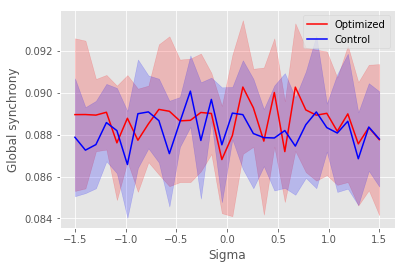

In [102]:
# Brede 3: Plot synchrony per sigma averaged over A
synchrony = 1 - np.array(R)
synchrony_control = 1 - np.array(R_control)
plt.plot(sigma, synchrony, color='r')
plt.fill_between(sigma, synchrony-R_err, synchrony+R_err,
    alpha=0.2, edgecolor='r', facecolor='r',antialiased=True)
plt.plot(sigma, 1 - np.array(R_control), color='b')
plt.fill_between(sigma, synchrony_control-R_control_err, synchrony_control+R_control_err,
    alpha=0.2, edgecolor='b', facecolor='b',antialiased=True)
plt.legend(('Optimized', 'Control'))
plt.xlabel('Sigma')
plt.ylabel('Global synchrony')
plt.show()
plt.close()
